# Pointwise Reliability: Density, Distance - Euclidean
Uses distances between a new instance and all preprocessed training points to assess reliability

## Workflow:
- Calculate the Euclidean distances from the instance to all points in the training data
- Identify points in the training set that belong to the same class as the predicted label for the new instance
- Count how many of these points are within a defined `distance_threshold` of the new instance (`same_label_points`)
- Compute reliability:
  - reliability=  `same_label_points` / `minimum_cluster_units`
    - `minimum_cluster_units` <- param 
    - If the `same_label_points` size is larger than the threshold (minimum units): reliability = 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import NearestNeighbors
from utils.reliability_visualizer import ReliabilityVisualizer

###########################################################
# Load Classifier and Data
###########################################################
pipeline = joblib.load('pipeline_classifier.pkl')
training_data = pd.read_csv("dataset/data_train.csv")

X_train = training_data.drop(columns=['SOURCE'])
y_train = training_data['SOURCE'].map({'out': 0, 'in': 1})
X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

/home/correia/Documents/Projects/SI/pointwise-benchmark/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/correia/Documents/Projects/SI/pointwise-benchmark/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/correia/Documents/Projects/SI/pointwise-benchmark/.venv/lib/python3.12/site-packages/sklearn/base.py:380:

In [2]:
###########################################################
# Reliability Calculation (Density - Distance: Euclidean)
###########################################################
def reliability_distance_based(new_instance, X_train_preprocessed, y_train, predicted_label, distance_threshold=0.10, target_instances=20):
    """
    Calculate the reliability based on euclidean distance and min. number of neighbors

    Reliability = 
        if (neighbors_new_instance < target_instances) 
            neighbors_new_instance / target_instances  
        else
            1

    Parameters:
    - new_instance: Preprocessed new instance.
    - X_train_preprocessed: Preprocessed training data.
    - y_train: Training labels.
    - predicted_label: Predicted class label of the new instance.
    - distance_threshold: The distance threshold for considering neighbors.
    - target_instances: Number of instances for full reliability.

    Returns:
    - reliability_score: [0; 1] reliability.
    """
    distances = np.linalg.norm(X_train_preprocessed - new_instance, axis=1)
    
    same_class_neighbors = (y_train == predicted_label)
    close_neighbors = np.sum((distances <= distance_threshold) & same_class_neighbors)
    
    reliability_score = min(close_neighbors / target_instances, 1.0)
    return reliability_score

In [3]:
###########################################################
# Classification and Reliability
###########################################################
def classify_and_check_reliability(new_data, pipeline, X_train_preprocessed, y_train, distance_threshold=0.10, target_instances=20):
    """
    Predicts the class and assesses reliability of a new instance.

    Parameters:
    - new_data (pd.DataFrame): DataFrame with the same columns as training data.
    - pipeline (Pipeline): The loaded pipeline for preprocessing and classification.
    - X_train_preprocessed: Preprocessed training data.
    - y_train: Training labels.
    - distance_threshold: The distance threshold for considering neighbors.
    - target_instances: The number of instances required for full reliability.

    Returns:
    - dict: Contains prediction and reliability score.
    """

    # Preprocess & Predict
    new_data_preprocessed = pipeline.named_steps['preprocessor'].transform(new_data)    
    predicted_label = pipeline.named_steps['classifier'].predict(new_data_preprocessed)[0]
    
    # Calculate reliability
    reliability_score = reliability_distance_based(
        new_data_preprocessed[0],
        X_train_preprocessed,
        y_train,
        predicted_label,
        distance_threshold,
        target_instances
    )
    
    return {
        "predicted_label": predicted_label,
        "reliability_score": reliability_score
    }

In [4]:
###########################################################
#  Load and Test with Unseen Data
###########################################################
validation_data = pd.read_csv("dataset/data_validation.csv")
validation_data['SOURCE'] = validation_data['SOURCE'].map({'out': 0, 'in': 1})
results = []

##############
### Adjust

distance_threshold = 0.10723016075771301
target_instances = 9

for _, instance in validation_data.iterrows():
    true_label = instance['SOURCE']
    instance_df = pd.DataFrame([instance.drop(labels=['SOURCE'])])
    result = classify_and_check_reliability(
        instance_df,
        pipeline,
        X_train_preprocessed,
        y_train,
        distance_threshold=distance_threshold,
        target_instances=target_instances
    )
    result['true_label'] = true_label
    results.append(result)

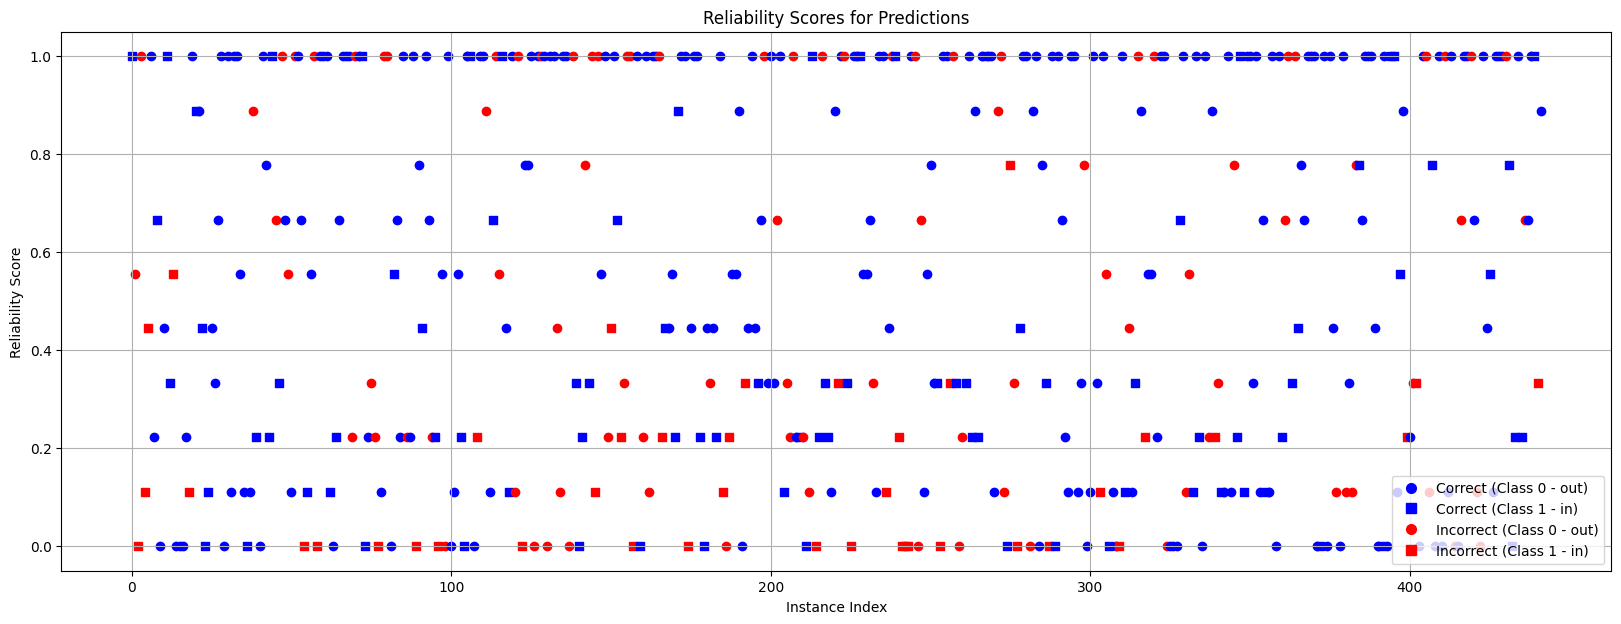

In [5]:
###########################################################
# Results
###########################################################
results_df = pd.DataFrame(results)

visualizer = ReliabilityVisualizer(results_df=results_df)
visualizer.plot_reliability_scores((20, 7))

In [6]:
reliability_table_df = visualizer.get_reliability_table_5()
print(reliability_table_df)

     Reliability  Correct (0)  Incorrect (0)  Correct (1)  Incorrect (1)
0   [0.00, 0.05]           28             11           14             18
1   ]0.05, 0.10]            0              0            0              0
2   ]0.10, 0.15]           23             11           10              6
3   ]0.15, 0.20]            0              0            0              0
4   ]0.20, 0.25]            9             10           19              8
5   ]0.25, 0.30]            0              0            0              0
6   ]0.30, 0.35]            8              8           13              5
7   ]0.35, 0.40]            0              0            0              0
8   ]0.40, 0.45]           13              2            5              2
9   ]0.45, 0.50]            0              0            0              0
10  ]0.50, 0.55]            0              0            0              0
11  ]0.55, 0.60]           13              5            3              1
12  ]0.60, 0.65]            0              0       

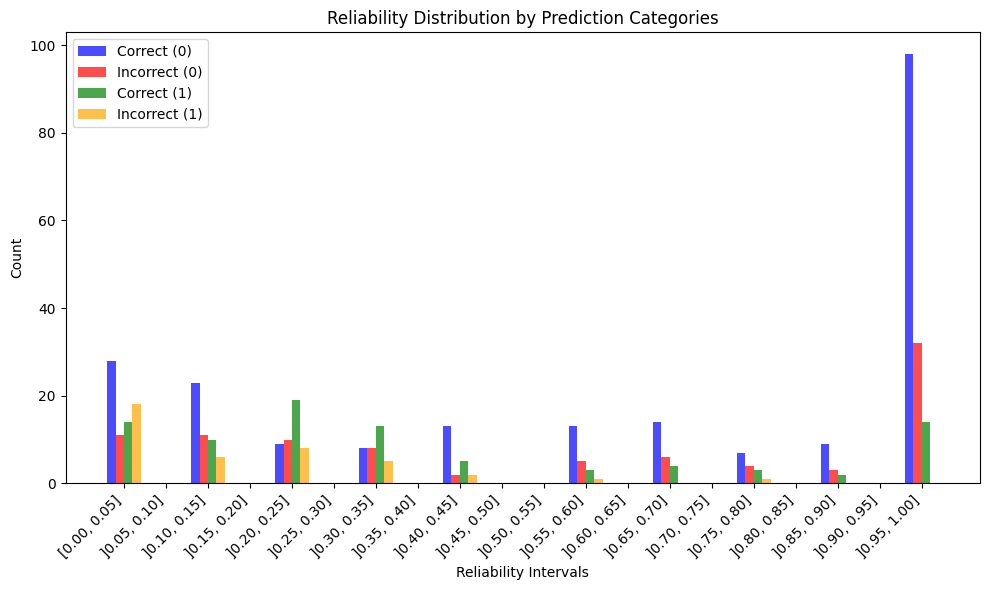

In [7]:
visualizer.plot_table_graph(reliability_table_df)

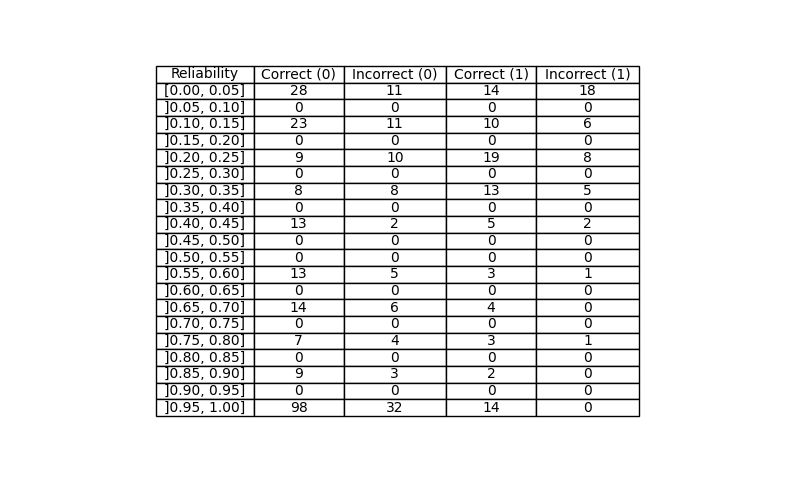

In [8]:
visualizer.plot_table_image(reliability_table_df)

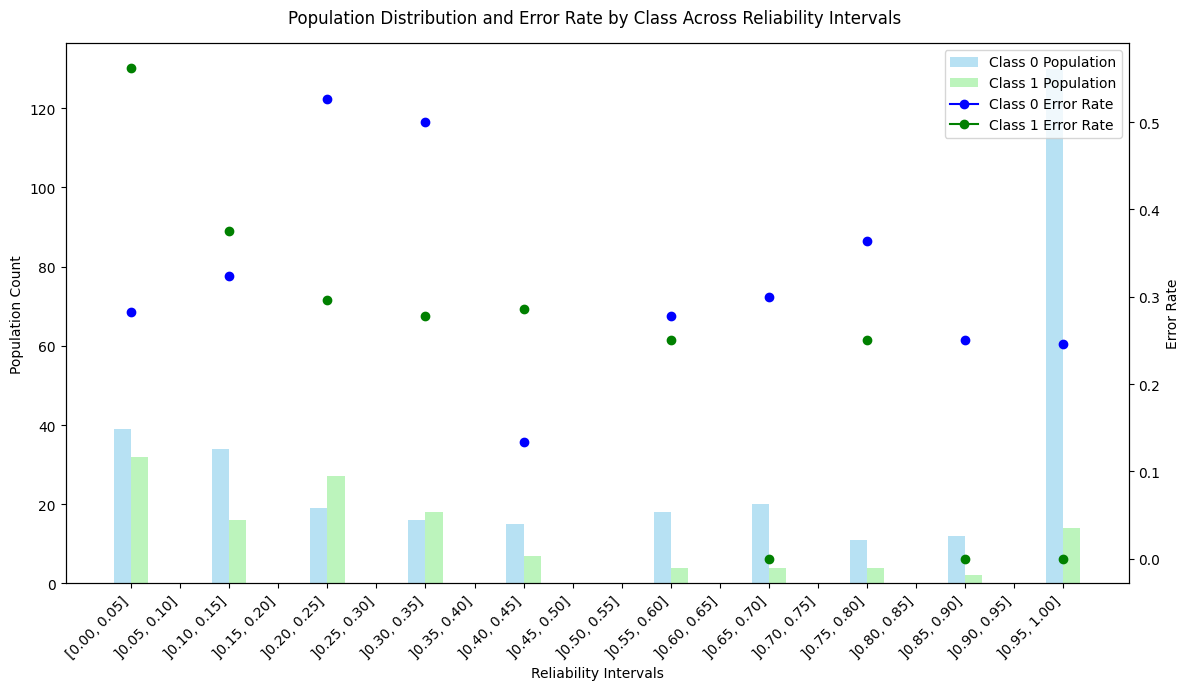

In [9]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_df)

### 10

In [10]:
reliability_table_10_df = visualizer.get_reliability_table_10()
print(reliability_table_10_df)

    Reliability  Correct (0)  Incorrect (0)  Correct (1)  Incorrect (1)
0  [0.00, 0.10]           28             11           14             18
1  ]0.10, 0.20]           23             11           10              6
2  ]0.20, 0.30]            9             10           19              8
3  ]0.30, 0.40]            8              8           13              5
4  ]0.40, 0.50]           13              2            5              2
5  ]0.50, 0.60]           13              5            3              1
6  ]0.60, 0.70]           14              6            4              0
7  ]0.70, 0.80]            7              4            3              1
8  ]0.80, 0.90]            9              3            2              0
9  ]0.90, 1.00]           98             32           14              0


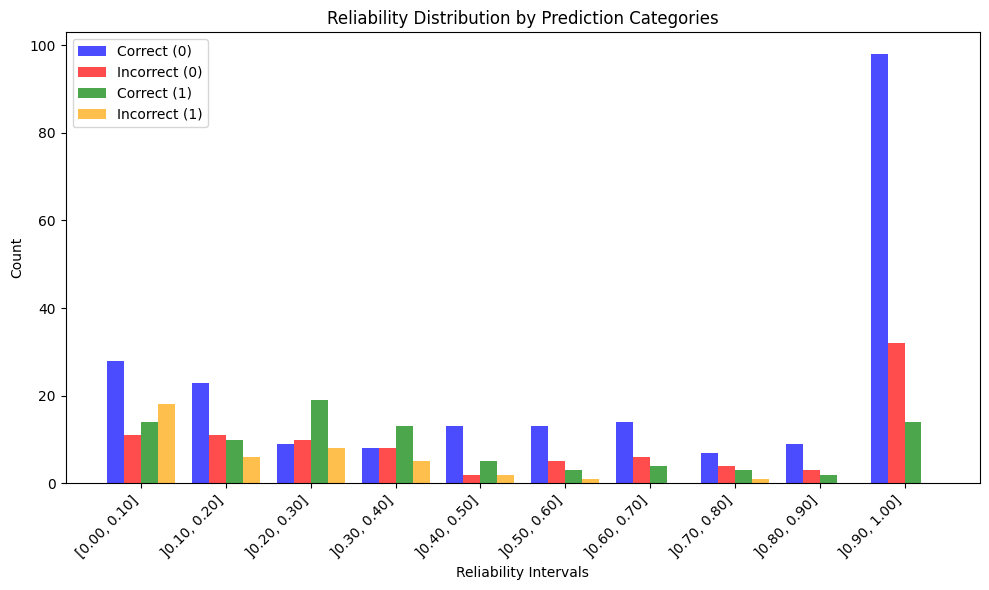

In [11]:
visualizer.plot_table_graph(reliability_table_10_df)

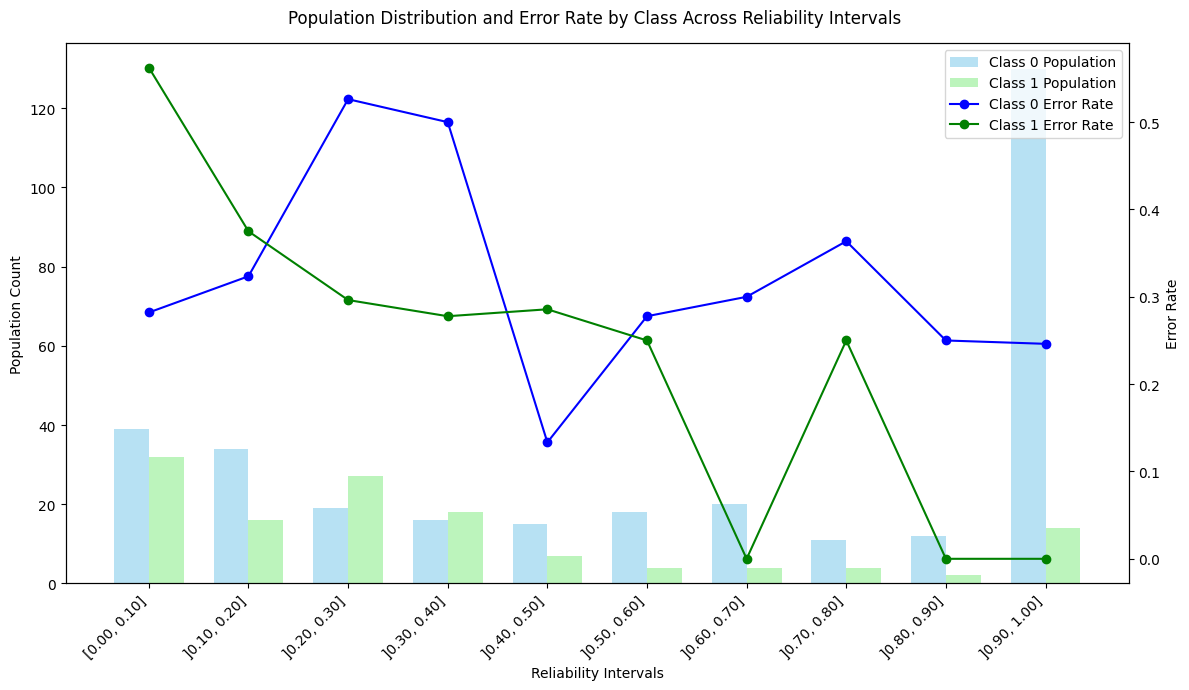

In [12]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_10_df)

Sample reliability interval assignment:
   reliability_score reliability_interval
0           1.000000           (0.9, 1.0]
1           0.555556           (0.5, 0.6]
2           0.000000        (-0.001, 0.1]
3           1.000000           (0.9, 1.0]
4           0.111111           (0.1, 0.2]
5           0.444444           (0.4, 0.5]
6           1.000000           (0.9, 1.0]
7           0.222222           (0.2, 0.3]
8           0.666667           (0.6, 0.7]
9           0.000000        (-0.001, 0.1]


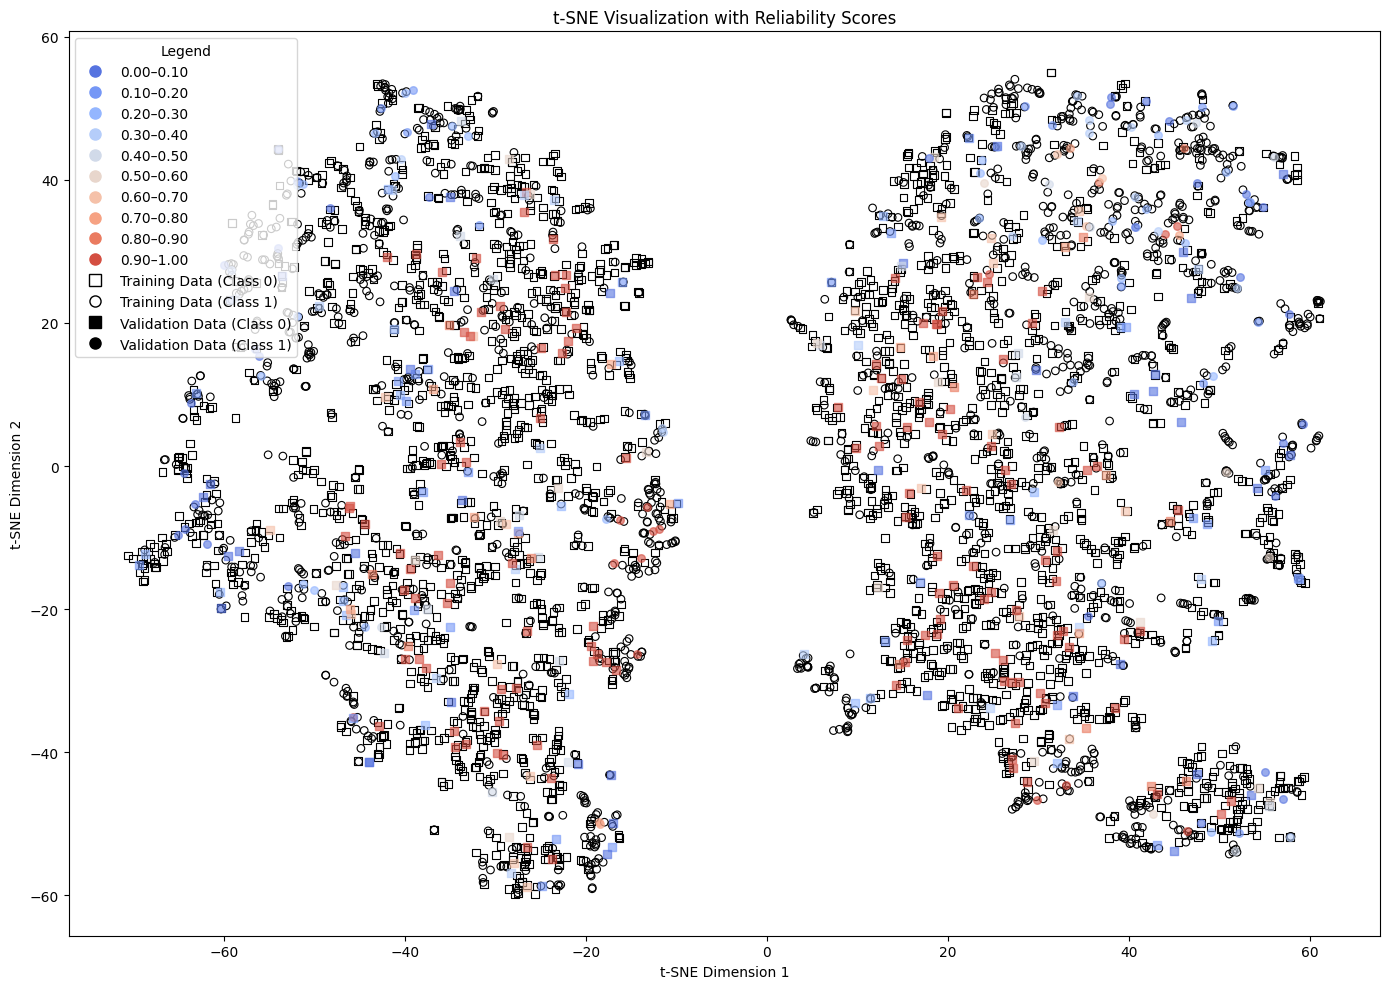

In [13]:
visualizer.plot_tsne_with_reliability(
    X_train_preprocessed, validation_data, y_train, pipeline
)